In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from environment import Environment, DirectedTree, DEFAULT, CONSTITUENT
from prouter import Router
from sampler import Sampler, strategies

In [9]:
def preparation_env():
    print(f"Preparing environment")
    env = Environment()
    print(f"Reading swmm-outfile")
    env.read_swmmoutfile(r"C:\Users\albert/Documents/SWMMpulse/HS_calib_120_simp.out")
    print(f"Preparing graph")
    graph = DirectedTree.from_swmm(r"C:\Users\albert/Documents/SWMMpulse/HS_calib_120_simp.inp")
    node_data = pd.read_csv(r"C:\Users\albert/Documents/SWMMpulse/HS_calib_120_simp/pop_node_data.csv")
    node_data = node_data.set_index("NAME").to_dict(orient="index")
    graph.add_nodevalues(node_data)
    env.add_graph(graph)
    print(f"finished preparing environment")
    return env

In [10]:
env = preparation_env()
router = Router()

router.add_environment(env)
packets = router.environment.get_packets()

routetable = router.route(packets=packets)

processed = router.postprocess(routetable, packets, DEFAULT.DEFAULT_CONSTITUENTS.get(CONSTITUENT.COV))

2022-03-25 11:38:11,781 Environment DEBUG  - pattern standardized
2022-03-25 11:38:11,787 Environment DEBUG  - pattern standardized
2022-03-25 11:38:11,788 Environment INFO  - Environment instance created
2022-03-25 11:38:11,789 Environment INFO  - Reading swmm-out-file to read flows


Preparing environment
Reading swmm-outfile


2022-03-25 11:38:14,978 Environment INFO  - Swmm-out-file read
2022-03-25 11:38:15,002 Environment DEBUG  - Graph of type <class 'environment.DirectedTree'> added
2022-03-25 11:38:15,013 Environment INFO  - Generating packets


Preparing graph
finished preparing environment


2022-03-25 11:38:17,682 Environment INFO  - 58913 packets generated
2022-03-25 11:38:17,690 Router INFO  - Routing packets
2022-03-25 11:38:21,707 Router INFO  - 511 packets routed
2022-03-25 11:38:21,777 Router INFO  - Postprocessing node MH4376405120 with flows from link MH327-088-1.1.
Constituent rounted: Cov-RNA
In groups: ['infected']
Preparing arrays...
2022-03-25 11:38:21,872 Router INFO  - arrays created in 0.0928964614868164 seconds
Calculating timeseries...
2022-03-25 11:38:21,966 Router INFO  - timeseries calculated in 0.0917806625366211 seconds
Aggregating timeseries...
2022-03-25 11:38:22,244 Router INFO  - timeseries aggregated in 0.27597784996032715 seconds



<AxesSubplot:>

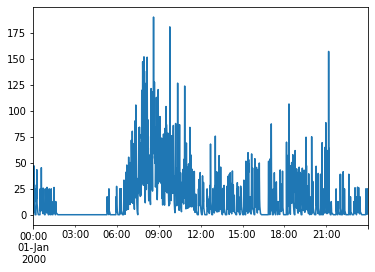

In [13]:
df = pd.DataFrame(processed, index=pd.date_range("2000-01-01", freq="10S", periods=8640))
df.sum(axis=1).plot()

In [24]:
sampler = Sampler()
sampler.sample(df_timeseries=df, strategy=strategies["A"])

KeyError: "None of [DatetimeIndex(['2022-03-25 00:00:00', '2022-03-25 00:00:10',\n               '2022-03-25 00:00:20', '2022-03-25 00:00:30',\n               '2022-03-25 00:00:40', '2022-03-25 00:00:50',\n               '2022-03-25 01:00:00', '2022-03-25 01:00:10',\n               '2022-03-25 01:00:20', '2022-03-25 01:00:30',\n               ...\n               '2022-03-25 22:00:20', '2022-03-25 22:00:30',\n               '2022-03-25 22:00:40', '2022-03-25 22:00:50',\n               '2022-03-25 23:00:00', '2022-03-25 23:00:10',\n               '2022-03-25 23:00:20', '2022-03-25 23:00:30',\n               '2022-03-25 23:00:40', '2022-03-25 23:00:50'],\n              dtype='datetime64[ns]', length=144, freq=None)] are in the [index]"

In [18]:
strategies

{'A': {'kind': 'time',
  'samplingfreq': '1H',
  'samplingduration': 60,
  'volume': 250},
 'B': {'kind': 'time',
  'samplingfreq': '0.3333333333333333H',
  'samplingduration': 60,
  'volume': 250},
 'C': {'kind': 'flow',
  'samplingfreq': '1H',
  'samplingduration': 60,
  'volume': 200},
 'D': {'kind': 'flow',
  'samplingfreq': '0.3333333333333333H',
  'samplingduration': 60,
  'volume': 200},
 'E': {'kind': 'volume',
  'samplecount': 24,
  'samplingduration': 60,
  'volume': 50},
 'F': {'kind': 'volume',
  'samplecount': 72,
  'samplingduration': 60,
  'volume': 250},
 'G': {'kind': 'grab',
  'samplingtime': datetime.time(9, 0),
  'samplingduration': 120,
  'volume': 1000},
 'H': {'kind': 'grab',
  'samplingtime': datetime.time(12, 0),
  'samplingduration': 120,
  'volume': 1000}}